In [45]:
import numpy as np

# -------------------- Helper Functions --------------------
def decode_particle(particle):
    y_size = n_products * m_machines
    y = particle[:y_size].reshape((n_products, m_machines)) #This array represents the quantities of each product assigned to each machine.
    z = particle[y_size:].reshape((w_workers, m_machines)) #This array represents the amount of time each worker spends on each machine.
    y = np.round(np.clip(y, 0, 1000))  # Quantity of products (integers)
    z = np.clip(z, 0, worker_max_time)  # Time spent by each worker
    return y, z

def evaluate(y, z):
    '''
    Calculate total profit:
    P_n is a 1D array of product profits (length n_products),
    y is n_products x m_machines quantity matrix,
    P_n[:, None] broadcasts P_n over columns,
    So P_n[:, None] * y gives profit contribution per product-machine,
    np.sum() sums over all products and machines for total profit.'''
    profit = np.sum(P_n[:, None] * y)
    penalties = 0
    
    # Constraint 1: Product-machine compatibility
    penalties += 1e5 * np.sum((1 - d_nm) * y)
    '''d_nm is a binary compatibility matrix (1 if product n can be produced on machine m, else 0).
    If y assigns products to incompatible machines (d_nm=0), multiply by 1e5 penalty (large) to discourage invalid assignments.'''
    '''What about the upper bound M_max
    on the quantity of products assigned to each machine?   
    The code implicitly uses 100 as a max quantity via the clipping and rounding step in decode_particle(), which acts as 
    the upper bound for product quantities assigned to each machine'''
    
    # Constraint 2: Machine time limit
    machine_time = np.sum(T_nm * y, axis=0)
    penalties += 1e4 * np.sum(np.maximum(machine_time - machine_max_time, 0))
    '''T_nm is time per unit product on each machine.
    machine_time is total machine time required: sum over products for each machine.
    If total machine time exceeds machine_max_time (e.g., 8 hours), add penalty proportional to the overload.'''
    
    # Constraint 3: Worker time limit
    worker_time = np.sum(z, axis=1)
    penalties += 1e4 * np.sum(np.maximum(worker_time - worker_max_time, 0))
    '''z is worker-machine time allocation.
    Sum over machines for each worker gives total time per worker.
    Penalize workers exceeding max available time (e.g., 8 hours).'''
    
    # Constraint 4: Worker-machine skill compatibility
    penalties += 1e5 * np.sum(z * (1 - s_wm))
    '''s_wm is skill compatibility binary matrix (1 if worker w can work on machine m).
    Penalize any worker time assigned to machines they are not skilled for.'''
    
    # Constraint 5: Worker time = machine time
    total_worker_time = np.sum(z, axis=0)
    required_machine_time = np.sum(T_nm * y, axis=0)
    penalties += 1e4 * np.sum(np.abs(total_worker_time - required_machine_time))
    '''Total time spent by all workers on each machine should match required machine time for producing assigned quantities.
    Penalize any mismatch.'''
    return -profit + penalties  # We minimize negative profit + penalties

def fitness(particle):
    '''# The fitness function evaluates a candidate solution (particle) in the PSO algorithm.
    # It first decodes the flat particle vector into two matrices:
    # - y: quantities of each product produced on each machine (integer values)
    # - z: time each worker spends on each machine (continuous values)
    # Then, it computes the fitness score by calling the evaluate() function,
    # which calculates the total negative profit plus penalty terms for any constraint violations.
    # The goal of the PSO is to minimize this fitness score, thereby maximizing profit while satisfying constraints.'''
    y, z = decode_particle(particle)
    return evaluate(y, z)

# --- NEW: Repair Mechanism ---
def repair_particle(particle_vector, max_repair_iters=20, tolerance=1e-3):
    '''# The repair_particle function attempts to fix an infeasible particle solution to satisfy problem constraints.
    # It takes a flattened particle vector (representing product quantities per machine and worker times per machine)
    # and iteratively adjusts it to enforce all constraints within a tolerance and a maximum number of iterations.
    #
    # Steps performed inside the repair:
    # 1. Product-machine compatibility: sets production quantities y to zero where product-machine compatibility is zero.
    # 2. Worker-machine skill compatibility: sets worker time allocations z to zero where the worker lacks the required skill.
    # 3. Machine time limits: scales down product quantities y on machines exceeding maximum allowed machine time.
    # 4. Worker time matches machine time: adjusts worker times z per machine to exactly cover the required machine running time,
    #    distributing deficits evenly among eligible workers or scaling down if there is excess.
    # 5. Worker total time limits: scales down each worker's total assigned time if exceeding their max working time.
    #
    # The process iterates up to max_repair_iters or until changes in y and z fall below a small tolerance.
    # Finally, it applies a last clamp to ensure no machine exceeds its max time.
    # The repaired y and z are flattened and returned as a valid particle vector that better respects constraints.'''
    y_size = n_products * m_machines
    y_flat = particle_vector[:y_size]
    z_flat = particle_vector[y_size:]

    y = y_flat.reshape((n_products, m_machines))
    z = z_flat.reshape((w_workers, m_machines))

    for _ in range(max_repair_iters):
        prev_y = y.copy()
        prev_z = z.copy()

        # 1. Product-machine compatibility
        #If a product is not compatible with a machine (d_nm == 0), set the quantity y on that machine to zero.
        y = np.where(d_nm == 0, 0, y)

        # 2. Worker-machine skill compatibility
        #If a worker does not have skill for a machine (s_wm == 0), set the time assigned z to zero.
        z = np.where(s_wm == 0, 0, z)
        #Clip and round the quantities y to be between 0 and 100 (cannot produce negative or excessively large amounts).
        y = np.round(np.clip(y, 0, 1000))
        #Clip the worker times z to be between 0 and the max allowed working time per worker.
        z = np.clip(z, 0, worker_max_time)

        # 3. Machine time limit
        '''For each machine, calculate total running time required by all products on it.
        If the total time exceeds the machine’s max allowed time, scale down all product quantities on that machine proportionally to fit under the limit.'''
        for m_idx in range(m_machines):
            machine_current_time = np.sum(T_nm[:, m_idx] * y[:, m_idx])
            if machine_current_time > machine_max_time:
                scaling_factor = (machine_max_time / machine_current_time)  
                y[:, m_idx] = np.floor(y[:, m_idx] * scaling_factor) #Scale down the product quantities on this machine by the scaling factor.
                y[:, m_idx] = np.maximum(y[:, m_idx], 0) #Ensure no quantity is negative after rounding (clip at zero minimum).
        #After adjusting quantities for all machines, recalculate the total running time needed per machine with the updated y.
        required_machine_time = np.sum(T_nm * y, axis=0)

    # Step 5: Ensure each worker does not exceed their max working time
    for w_idx in range(w_workers):
        total_time = np.sum(z[w_idx, :])
        if total_time > worker_max_time:
            # Scale down all assigned times for this worker proportionally
            scale = worker_max_time / total_time
            z[w_idx, :] = z[w_idx, :] * scale

    # Step 4: Make sure total worker time matches machine time requirements per machine
    for m_idx in range(m_machines):
        eligible_workers = np.where(s_wm[:, m_idx] == 1)[0]  # workers skilled on this machine
        
        if len(eligible_workers) == 0:
            # No eligible workers: no production possible on this machine
            required_machine_time[m_idx] = 0
            y[:, m_idx] = 0
            continue
        
        current_req_time = required_machine_time[m_idx]        # machine time needed
        current_worker_time = np.sum(z[:, m_idx])               # total worker time assigned
        
        deficit = current_req_time - current_worker_time        # how much more time is needed
        
        if deficit <= 0:
            # Workers are assigned enough or more time than required
            if current_worker_time > 0:
                # Scale down worker times to exactly match machine time
                scale = current_req_time / current_worker_time
                z[:, m_idx] = z[:, m_idx] * scale
        else:
            # Deficit exists: check if workers have enough available capacity to cover it
            available_capacity = 0
            for w_idx in eligible_workers:
                available_capacity += (worker_max_time - np.sum(z[w_idx, :]))
            
            if available_capacity >= deficit:
                # Distribute deficit evenly among eligible workers without exceeding max time
                distribute = deficit / len(eligible_workers)
                for w_idx in eligible_workers:
                    z[w_idx, m_idx] += distribute
            else:
                # Not enough worker capacity to cover deficit
                # Scale down production quantities on this machine to fit worker limits
                scale = available_capacity / deficit if deficit > 0 else 0
                y[:, m_idx] = np.floor(y[:, m_idx] * scale)  # round down to keep integers
                # Update required machine time accordingly after scaling production
                required_machine_time[m_idx] = np.sum(T_nm[:, m_idx] * y[:, m_idx])
                # Assign worker time exactly equal to new required machine time
                z[:, m_idx] = 0
                distribute = required_machine_time[m_idx] / len(eligible_workers)
                for w_idx in eligible_workers:
                    z[w_idx, m_idx] += distribute


        z = np.clip(z, 0, worker_max_time)

        # Check convergence: if y and z changed very little, break early
        delta_y = np.linalg.norm(y - prev_y)
        delta_z = np.linalg.norm(z - prev_z)
        if delta_y < tolerance and delta_z < tolerance:
                break
    # Final clamp to fix any tiny overload leftover
    for m_idx in range(m_machines):
        machine_time = np.sum(T_nm[:, m_idx] * y[:, m_idx])
        if machine_time > machine_max_time:
            scale = machine_max_time / machine_time
            y[:, m_idx] = np.round(y[:, m_idx] * scale)
            y[:, m_idx] = np.maximum(y[:, m_idx], 0)
    # Ensure y and z are still within bounds   
    # Flatten back to particle vector
    return np.concatenate((y.flatten(), z.flatten()))

# -------------------- Feasible Particle Initialization --------------------

def initialize_feasible_particle():
    y = np.zeros((n_products, m_machines))  # Product quantities
    z = np.zeros((w_workers, m_machines))   # Worker time assignments

    available_worker_time = np.full(w_workers, worker_max_time)  # Worker time budget

    for m_idx in range(m_machines):
        compatible_products = np.where(d_nm[:, m_idx] == 1)[0]
        eligible_workers = np.where(s_wm[:, m_idx] == 1)[0]
        np.random.shuffle(compatible_products)
        np.random.shuffle(eligible_workers)

        # Estimate total available time for this machine from eligible workers
        total_worker_time_available = np.sum(available_worker_time[eligible_workers])
        machine_time_budget = min(machine_max_time, total_worker_time_available)

        remaining_machine_time = machine_time_budget

        # --- Step 1: Assign Products to Machine ---
        for n_idx in compatible_products:
            time_per_unit = T_nm[n_idx, m_idx]
            if time_per_unit == 0:
                continue

            # Maximum allowed by remaining machine time
            max_qty_machine = int(remaining_machine_time // time_per_unit)

            # Maximum allowed by workers' available time on this machine
            total_worker_time_available = np.sum(available_worker_time[eligible_workers])
            max_qty_workers = int(total_worker_time_available // time_per_unit)

            # True max quantity: bounded by both machine and worker capacity
            true_max_qty = min(max_qty_machine, max_qty_workers)

            if true_max_qty <= 0:
                continue

            qty = np.random.randint(0, true_max_qty + 1)
            y[n_idx, m_idx] = qty
            used_time = qty * time_per_unit
            remaining_machine_time -= used_time

    # We’ll reduce worker capacity **after** full product assignment per machine

        # --- Step 2: Assign Workers to Fulfill Machine Time ---
        total_machine_time = np.sum(T_nm[:, m_idx] * y[:, m_idx])

        # Recheck total_worker_time_available to avoid division by zero
        if total_machine_time > 0 and len(eligible_workers) > 0:
            per_worker_time = total_machine_time / len(eligible_workers)

            # Assign per-worker time, respecting individual caps
            for w_idx in eligible_workers:
                assign_time = min(per_worker_time, available_worker_time[w_idx])
                z[w_idx, m_idx] = assign_time
                available_worker_time[w_idx] -= assign_time

            # Fix if assigned time doesn't match required machine time
            assigned_time = np.sum(z[eligible_workers, m_idx])
            if assigned_time < total_machine_time:
                scale = total_machine_time / assigned_time
                for w_idx in eligible_workers:
                    current = z[w_idx, m_idx]
                    adjusted = min(current * scale, available_worker_time[w_idx] + current)
                    available_worker_time[w_idx] += current  # restore before reassign
                    z[w_idx, m_idx] = adjusted
                    available_worker_time[w_idx] -= adjusted

    # Final check: no worker exceeds max time
    for w_idx in range(w_workers):
        total = np.sum(z[w_idx, :])
        if total > worker_max_time:
            z[w_idx, :] *= worker_max_time / total
            available_worker_time[w_idx] = 0

    return np.concatenate((y.flatten(), z.flatten()))

# -------------------- PSO Algorithm --------------------
def run_pso(): 
    # Total dimension of each particle = number of decision variables (y and z)
    # y: quantities of products per machine (n_products * m_machines)
    # z: worker time assignments per machine (w_workers * m_machines)
    dim = n_products * m_machines + w_workers * m_machines 
     # Initialize particles, then repair them to be feasible 
    #particles = np.random.rand(n_particles, dim) * 10 
    #for i in range(n_particles): 
    #    particles[i] = repair_particle(particles[i]) 
 
    # Initialize particles with feasible solutions
    particles = np.array([initialize_feasible_particle() for _ in range(n_particles)])
    #particles = np.array([repair_particle(initialize_feasible_particle()) for _ in range(n_particles)])

    # Initialize particle velocities with standard normal random values
    # Initialize velocities with values between -3 and 3
    # Why use a symmetric range (-3 to 3)?
    # - Allows particles to move in both positive and negative directions,
    #   enabling balanced exploration across the search space.
    # - Prevents directional bias (e.g., only moving right or up),
    #   which could trap the swarm in one region.
    #
    # Using a positive-only range like (0 to 3) limits movement
    # to one direction per axis and reduces the algorithm’s effectiveness.
    v_max = 3.0
    vmin = -3.0
    vmax = v_max

    velocities = np.random.uniform(low=vmin, high=vmax, size=(n_particles, dim))
    #i stopped here
    # Initialize personal best positions and their fitness scores for all particles
    pbest_positions = particles.copy() 
    pbest_scores = np.array([fitness(p) for p in particles])  # Evaluate fitness for each particle
 
    # Identify global best position and score among all particles
    gbest_index = np.argmin(pbest_scores)  # Minimization problem, so lowest fitness is best
    gbest_position = pbest_positions[gbest_index].copy() 
    gbest_score = pbest_scores[gbest_index] 
 
    # Main PSO loop: iterate for a fixed number of iterations
    stagnation_counter = 0
    max_stagnation = 15
    last_gbest_score = gbest_score
    global best_scores
    global actual_profits
    global penaltiess 
    global w
    global c1
    global c2
    for iter in range(iterations):
        for i in range(n_particles):
            # Generate two random vectors r1 and r2, each of length equal to the problem dimension.
            # These are sampled from a uniform distribution between 0 and 1.
            # - r1 controls randomness in the cognitive component (particle’s own experience).
            # - r2 controls randomness in the social component (swarm’s experience).
            # This stochastic behavior promotes exploration and prevents premature convergence.
            r1, r2 = np.random.rand(dim), np.random.rand(dim)

            # Update velocity and position
            velocities[i] = (w * velocities[i]
                            + c1 * r1 * (pbest_positions[i] - particles[i])
                            + c2 * r2 * (gbest_position - particles[i]))
            particles[i] += velocities[i]
            particles[i] = repair_particle(particles[i])  # Ensure feasibility

            # Evaluate fitness
            score = fitness(particles[i])

            # Update personal best
            if score < pbest_scores[i]:
                pbest_scores[i] = score
                pbest_positions[i] = particles[i].copy()

                # Update global best
                if score < gbest_score:
                    gbest_score = score
                    gbest_position = particles[i].copy()

        # Track stagnation: has the best score changed?
        if abs(gbest_score - last_gbest_score) < 1e-6:
            stagnation_counter += 1
        else:
            stagnation_counter = 0
            last_gbest_score = gbest_score
        ###############
        # Decode the best particle to get y and z, then calculate real profit and penalties
        y_decoded, z_decoded = decode_particle(gbest_position)
        real_profit = np.sum(P_n[:, None] * y_decoded)
        penalties = (
            1e5 * np.sum((1 - d_nm) * y_decoded) +
            1e4 * np.sum(np.maximum(np.sum(T_nm * y_decoded, axis=0) - machine_max_time, 0)) +
            1e4 * np.sum(np.maximum(np.sum(z_decoded, axis=1) - worker_max_time, 0)) +
            1e5 * np.sum(z_decoded * (1 - s_wm)) +
            1e4 * np.sum(np.abs(np.sum(z_decoded, axis=0) - np.sum(T_nm * y_decoded, axis=0)))
        )
        print(f"Iteration {iter}: Best Objective = {gbest_score:.2f}, Profit = {real_profit:.2f}, Penalties = {penalties:.2f}")

        # Append scores and profits for analysis
        best_scores.append(gbest_score)
        actual_profits.append(real_profit)
        penaltiess.append(penalties)
        # Print progress every 10 iterations
        '''if iter % 10 == 0:
            y_decoded, z_decoded = decode_particle(gbest_position)
            real_profit = np.sum(P_n[:, None] * y_decoded)
            penalties = (
                1e5 * np.sum((1 - d_nm) * y_decoded) +
                1e4 * np.sum(np.maximum(np.sum(T_nm * y_decoded, axis=0) - machine_max_time, 0)) +
                1e4 * np.sum(np.maximum(np.sum(z_decoded, axis=1) - worker_max_time, 0)) +
                1e5 * np.sum(z_decoded * (1 - s_wm)) +
                1e4 * np.sum(np.abs(np.sum(z_decoded, axis=0) - np.sum(T_nm * y_decoded, axis=0)))
            )
            
            print(f"Iteration {iter}: Best Objective = {gbest_score:.2f}, Profit = {real_profit:.2f}, Penalties = {penalties:.2f}")'''
        if max_stagnation <= 0:
            print(f"Max stagnation reached. Stopping optimization.")
            break     
        # Early stopping condition
        if stagnation_counter >= max_stagnation:
            print(f"Stagnation detected at iteration {iter}. Tuning PSO parameters...")
            max_stagnation=max_stagnation-10
            max_stagnation=max(0, max_stagnation)  # Reduce max stagnation to avoid infinite loops
            # Example: increase exploration by raising inertia and lowering learning rates
            w = min(w + 0.15, 0.95)   # Increase inertia (up to a max)
            c1 = max(c1 - 0.3, 2)  # Decrease cognitive
            c2 = max(c2 - 0.3, 1.0)  # Decrease social
            stagnation_counter = 0    # Reset stagnation counter
            # Optionally, re-randomize velocities to shake up the swarm
            velocities = np.random.uniform(low=-3, high=3, size=velocities.shape)
            continue  # Continue optimization with new parameters
          
    # Return best found particle and its profit (negative of best score since score = -profit + penalties)
    return gbest_position, -gbest_score






In [46]:
# -------------------- Problem Parameters --------------------
n_products = 20       # Number of products
m_machines = 50        # Number of machines
w_workers = 60       # Number of workers

P_n = np.random.uniform(10, 100, n_products)          # Profit per unit product
T_nm = np.random.uniform(0.2, 2.0, (n_products, m_machines))  # Time for each product on each machine
d_nm = np.random.choice([0, 1], size=(n_products, m_machines), p=[0.5, 0.5])  # Product-machine compatibility (0/1)
s_wm = np.random.choice([0, 1], size=(w_workers, m_machines), p=[0.3, 0.7])  # Worker-machine skill (0/1)

machine_max_time = 8   # Max hours machine can run
worker_max_time = 8    # Max hours worker can work
best_scores = []
actual_profits = []
penaltiess = []

# -------------------- PSO Parameters --------------------
n_particles = 100
w = 0.7  # less inertia
c1 = 1.5 # more personal learning
c2 = 1.5 # more global learning
iterations = 100

# -------------------- Run and Output --------------------
best_solution_vector, best_objective_score_with_penalties = run_pso()

# Decode best particle
best_y, best_z = decode_particle(best_solution_vector)

# Compute real profit (no penalty)
real_profit = np.sum(P_n[:, None] * best_y)

Iteration 0: Best Objective = -14905.16, Profit = 14905.16, Penalties = 0.00
Iteration 1: Best Objective = -17413.63, Profit = 17413.63, Penalties = 0.00
Iteration 2: Best Objective = -20399.03, Profit = 20399.03, Penalties = 0.00
Iteration 3: Best Objective = -24113.05, Profit = 24113.05, Penalties = 0.00
Iteration 4: Best Objective = -28244.27, Profit = 28244.27, Penalties = 0.00
Iteration 5: Best Objective = -31157.63, Profit = 31157.63, Penalties = 0.00
Iteration 6: Best Objective = -35200.65, Profit = 35200.65, Penalties = 0.00
Iteration 7: Best Objective = -36971.15, Profit = 36971.15, Penalties = 0.00
Iteration 8: Best Objective = -38092.60, Profit = 38092.60, Penalties = 0.00
Iteration 9: Best Objective = -39544.17, Profit = 39544.17, Penalties = 0.00
Iteration 10: Best Objective = -40930.66, Profit = 40930.66, Penalties = 0.00
Iteration 11: Best Objective = -41873.11, Profit = 41873.11, Penalties = 0.00
Iteration 12: Best Objective = -42088.33, Profit = 42088.33, Penalties = 0

In [47]:
print("\n--- Optimization Results ---")
print("✅ Final Best Objective Score (with penalties):", best_objective_score_with_penalties)
print("💰 Actual Profit (from final best solution, without penalties):", real_profit)

# Optional: Check constraint violations of the final solution
print("\n--- Constraint Violations (should be close to zero if repair is effective) ---")
print("🔍 Infeasible y (product-machine compatibility):", np.sum((1 - d_nm) * best_y))
print("⚙️ Machine overload:", np.sum(np.maximum(np.sum(T_nm * best_y, axis=0) - machine_max_time, 0)))
print("👷 Worker overload:", np.sum(np.maximum(np.sum(best_z, axis=1) - worker_max_time, 0)))
print("🔧 Skill mismatch:", np.sum(best_z * (1 - s_wm)))
print("⏱ Time mismatch:", np.sum(np.abs(np.sum(best_z, axis=0) - np.sum(T_nm * best_y, axis=0))))




--- Optimization Results ---
✅ Final Best Objective Score (with penalties): 43294.131063904635
💰 Actual Profit (from final best solution, without penalties): 43294.131063905064

--- Constraint Violations (should be close to zero if repair is effective) ---
🔍 Infeasible y (product-machine compatibility): 0.0
⚙️ Machine overload: 0.0
👷 Worker overload: 0.0
🔧 Skill mismatch: 0.0
⏱ Time mismatch: 4.263256414560601e-14


In [48]:
print("\n--- Final Assignment Matrix: Products per Machine (y) ---")
nonzero_y = np.argwhere(best_y > 0)
if nonzero_y.size == 0:
    print("No products were assigned.")
else:
    for n_idx, m_idx in nonzero_y:
        print(f"Product {n_idx} → Machine {m_idx} : Quantity = {int(best_y[n_idx, m_idx])}")



--- Final Assignment Matrix: Products per Machine (y) ---
Product 0 → Machine 6 : Quantity = 12
Product 0 → Machine 18 : Quantity = 17
Product 1 → Machine 14 : Quantity = 6
Product 1 → Machine 25 : Quantity = 6
Product 1 → Machine 33 : Quantity = 22
Product 1 → Machine 35 : Quantity = 24
Product 2 → Machine 24 : Quantity = 5
Product 2 → Machine 31 : Quantity = 6
Product 3 → Machine 34 : Quantity = 5
Product 3 → Machine 43 : Quantity = 29
Product 4 → Machine 7 : Quantity = 11
Product 4 → Machine 36 : Quantity = 10
Product 4 → Machine 38 : Quantity = 9
Product 4 → Machine 41 : Quantity = 21
Product 4 → Machine 44 : Quantity = 6
Product 4 → Machine 46 : Quantity = 15
Product 5 → Machine 20 : Quantity = 7
Product 6 → Machine 4 : Quantity = 21
Product 6 → Machine 15 : Quantity = 22
Product 6 → Machine 39 : Quantity = 23
Product 6 → Machine 42 : Quantity = 16
Product 7 → Machine 0 : Quantity = 15
Product 7 → Machine 22 : Quantity = 18
Product 8 → Machine 37 : Quantity = 31
Product 8 → Machi

In [49]:
print("\n--- Final Assignment Matrix: Worker Time per Machine (z) ---")
nonzero_z = np.argwhere(best_z > 0)
if nonzero_z.size == 0:
    print("No workers were assigned.")
else:
    for w_idx, m_idx in nonzero_z:
        print(f"Worker {w_idx} → Machine {m_idx} : Time = {best_z[w_idx, m_idx]:.2f}")



--- Final Assignment Matrix: Worker Time per Machine (z) ---
Worker 0 → Machine 3 : Time = 0.02
Worker 0 → Machine 6 : Time = 0.01
Worker 0 → Machine 7 : Time = 0.01
Worker 0 → Machine 9 : Time = 0.08
Worker 0 → Machine 10 : Time = 0.00
Worker 0 → Machine 11 : Time = 0.01
Worker 0 → Machine 14 : Time = 0.00
Worker 0 → Machine 17 : Time = 0.02
Worker 0 → Machine 18 : Time = 0.07
Worker 0 → Machine 21 : Time = 0.04
Worker 0 → Machine 23 : Time = 0.02
Worker 0 → Machine 25 : Time = 0.94
Worker 0 → Machine 26 : Time = 0.00
Worker 0 → Machine 30 : Time = 0.00
Worker 0 → Machine 32 : Time = 0.03
Worker 0 → Machine 33 : Time = 0.00
Worker 0 → Machine 35 : Time = 2.44
Worker 0 → Machine 36 : Time = 0.00
Worker 0 → Machine 37 : Time = 0.29
Worker 0 → Machine 40 : Time = 0.03
Worker 0 → Machine 42 : Time = 0.05
Worker 0 → Machine 43 : Time = 0.01
Worker 0 → Machine 44 : Time = 0.08
Worker 0 → Machine 45 : Time = 0.86
Worker 0 → Machine 48 : Time = 0.02
Worker 1 → Machine 0 : Time = 0.43
Worker 

In [50]:
# If needed: Total machine time usage
print("\n🧮 Machine Time Used (per machine):")
print(np.sum(T_nm * best_y, axis=0))




🧮 Machine Time Used (per machine):
[7.54187819 7.80351785 7.69628797 7.60202127 7.93821703 7.73219438
 7.62220678 7.7347693  7.61260382 6.94153653 6.9654605  7.82875512
 7.85533689 7.77177655 7.82530476 7.70874203 7.80279471 7.86516763
 7.88700153 6.70730031 7.17961762 7.89833271 7.77181259 7.96346443
 7.30272261 7.9444054  7.87834197 7.53063526 7.88393944 6.7311302
 7.49191282 7.2144969  7.73157647 7.7191283  7.74839952 7.80502438
 7.87147689 7.82671581 7.34978754 7.86431576 7.41099396 7.96211037
 7.80353627 7.88759475 7.84723216 7.74583221 7.96472655 7.87256528
 7.67333262 7.99957963]


In [51]:
# Total worker time usage
print("\n👷 Total Time Assigned per Worker:")
print(np.sum(best_z, axis=1))


👷 Total Time Assigned per Worker:
[5.06324181 5.56627328 6.51190462 7.61970777 2.28954959 7.75890815
 4.35668989 6.84677263 7.2956037  7.79459469 7.30919161 7.76938322
 6.62472825 6.3242141  7.11657534 7.4828508  7.11526203 6.0003186
 6.95462595 5.54279173 3.10714607 7.29380702 6.62591099 5.83988964
 6.5806646  5.78686761 6.09036359 6.8404148  7.32338856 7.4305324
 7.55359613 5.19117276 6.94644159 6.28608145 7.14468604 7.96591454
 3.89084344 6.7013919  6.27964374 4.18003295 7.04390026 6.85425552
 6.3110554  7.73781864 3.21531103 7.14061463 6.15302305 7.92690238
 5.29846331 7.43030524 7.82185922 6.34025635 6.96023234 3.4679761
 7.1261441  7.37610269 7.10878892 6.82595703 4.9479593  5.82871049]


In [52]:
print(best_z.shape)

(60, 50)


In [53]:
print("\n--- Number of Machines Each Worker is Assigned To ---")
machines_per_worker = np.sum(best_z > 0, axis=1)

for w_idx, count in enumerate(machines_per_worker):
    print(f"Worker {w_idx}: assigned to {count} machine(s)")



--- Number of Machines Each Worker is Assigned To ---
Worker 0: assigned to 25 machine(s)
Worker 1: assigned to 27 machine(s)
Worker 2: assigned to 31 machine(s)
Worker 3: assigned to 29 machine(s)
Worker 4: assigned to 33 machine(s)
Worker 5: assigned to 30 machine(s)
Worker 6: assigned to 25 machine(s)
Worker 7: assigned to 32 machine(s)
Worker 8: assigned to 31 machine(s)
Worker 9: assigned to 29 machine(s)
Worker 10: assigned to 28 machine(s)
Worker 11: assigned to 34 machine(s)
Worker 12: assigned to 29 machine(s)
Worker 13: assigned to 33 machine(s)
Worker 14: assigned to 34 machine(s)
Worker 15: assigned to 29 machine(s)
Worker 16: assigned to 26 machine(s)
Worker 17: assigned to 33 machine(s)
Worker 18: assigned to 29 machine(s)
Worker 19: assigned to 32 machine(s)
Worker 20: assigned to 32 machine(s)
Worker 21: assigned to 31 machine(s)
Worker 22: assigned to 21 machine(s)
Worker 23: assigned to 25 machine(s)
Worker 24: assigned to 27 machine(s)
Worker 25: assigned to 32 mach

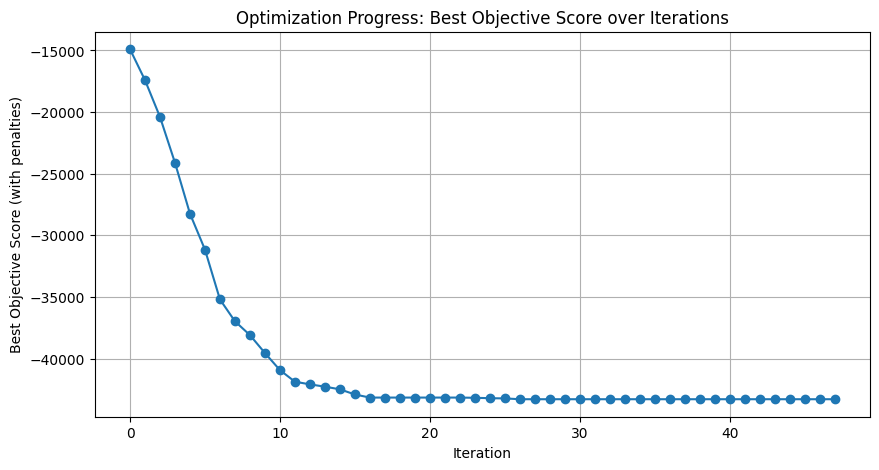

In [54]:
import matplotlib.pyplot as plt

# Suppose you stored best scores at each iteration in a list:
# best_scores = [score_iter_0, score_iter_1, ..., score_iter_n]

plt.figure(figsize=(10, 5))
plt.plot(best_scores, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Best Objective Score (with penalties)')
plt.title('Optimization Progress: Best Objective Score over Iterations')
plt.grid(True)
plt.show()


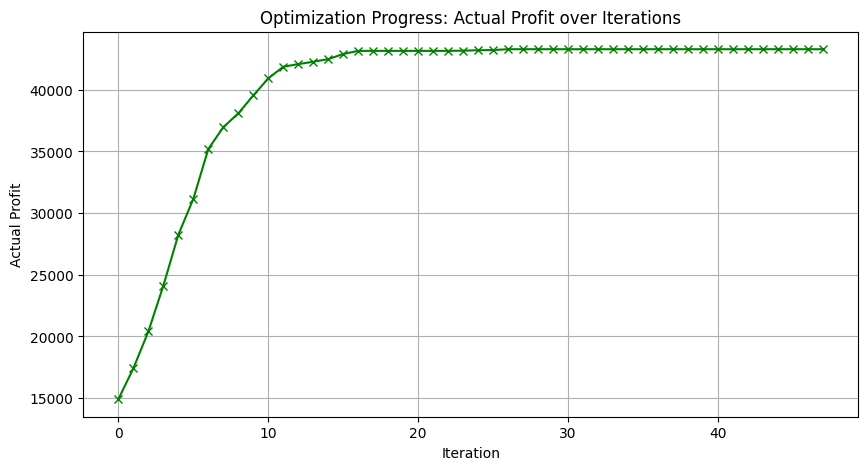

In [55]:
# actual_profits = [profit_iter_0, profit_iter_1, ..., profit_iter_n]

plt.figure(figsize=(10, 5))
plt.plot(actual_profits, color='green', marker='x')
plt.xlabel('Iteration')
plt.ylabel('Actual Profit')
plt.title('Optimization Progress: Actual Profit over Iterations')
plt.grid(True)
plt.show()


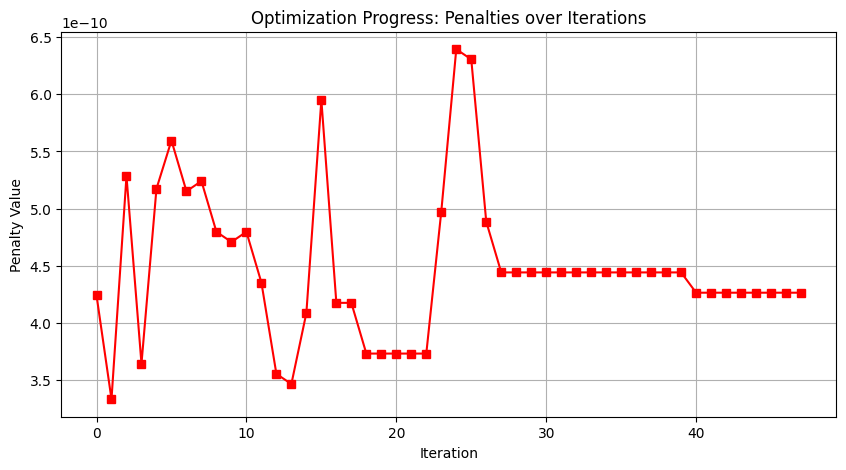

In [56]:
# penalties = [penalty_iter_0, penalty_iter_1, ..., penalty_iter_n]

plt.figure(figsize=(10, 5))
plt.plot(penaltiess, color='red', marker='s')
plt.xlabel('Iteration')
plt.ylabel('Penalty Value')
plt.title('Optimization Progress: Penalties over Iterations')
plt.grid(True)
plt.show()
